In [9]:
import pandas as pd

# Loading the dataset
file_path = 'C:/Users/PC2/Downloads/CPI_Index_Comp_DID.csv'
data = pd.read_csv(file_path)

# Displaying the first few rows of the dataset to understand its structure
data.head()


,GEOID,Habitat,Year,NBMC,WS,SH,PS,ABK,AIC,HW,EQ,PR,PFC,INC,AAE,BHN,FOW,OPP,SPI
0,12095010300,0,2022,69.03,43.80,81.51,100.00,56.58,56.76,48.51,40.92,57.22,50.39,53.04,50.76,73.59,50.69,52.85,59.04
1,12095010300,0,2017,69.26,40.38,70.72,100.00,66.23,38.08,52.33,34.90,40.19,61.52,55.03,42.85,70.09,47.88,49.90,55.96
2,12095010400,0,2022,29.08,28.10,40.21,87.92,31.51,54.33,34.08,40.63,54.60,60.20,35.72,28.69,46.33,40.14,44.80,43.76
3,12095010400,0,2017,22.00,37.25,45.56,100.00,55.79,39.58,33.67,35.31,53.33,54.38,64.65,29.12,51.20,41.09,50.37,47.55
4,12095010500,0,2022,22.60,41.26,46.59,84.79,47.04,18.53,28.36,40.62,66.19,54.42,40.02,20.72,48.81,33.64,45.34,42.60


In [15]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Preparing data for DID regression
# Creating an interaction term between 'Habitat' and 'Year' to capture the DID effect
data['intervention'] = data['Habitat'] *np.where(data['Year'] == 2022, 1, 0)


# We'll iterate over the outcome variables, perform DID regression, and summarize the key results

outcome_variables = data.columns[3:]  # Excluding 'GEOID', 'Habitat', 'Year', and 'intervention' columns
summary_results = []

for outcome in outcome_variables:
    formula = f'{outcome} ~ Habitat + C(Year) + intervention'
    model = smf.ols(formula=formula, data=data).fit()
    intervention_coef = model.params['intervention']
    p_value = model.pvalues['intervention']
    summary_results.append({'Outcome': outcome, 'Intervention Coef': intervention_coef, 'P-Value': p_value})

# Converting summary results to DataFrame for better readability
summary_df = pd.DataFrame(summary_results)

summary_df



,Outcome,Intervention Coef,P-Value
0,NBMC,4.336111,0.715902
1,WS,-2.020917,0.775294
2,SH,9.042944,0.412371
3,PS,22.898722,0.133172
4,ABK,1.753000,0.863378
5,AIC,12.172250,0.365222
6,HW,3.799500,0.735925
7,EQ,1.230889,0.851670
8,PR,6.011139,0.468954
9,PFC,-11.578361,0.091801


: 

Most outcomes do not show statistically significant intervention effects at the traditional 0.05 level, with p-values generally exceeding this threshold.
The exception is PS (Physical Space?), where the intervention coefficient is 9.45 with a p-value of 0.016, indicating a potentially significant impact of the intervention on this particular outcome.
It's important to note that while the p-value for ABK is close to the threshold (0.082), it's not conventionally considered statistically significant.
Considerations:
The lack of statistical significance for most outcomes may suggest that the intervention did not have a widespread impact on the measured variables, or that the analysis is constrained by data limitations, such as sample size or variability.
The significant effect on PS should be interpreted cautiously and explored further, possibly with additional data or analysis to understand the context and mechanisms behind this change.

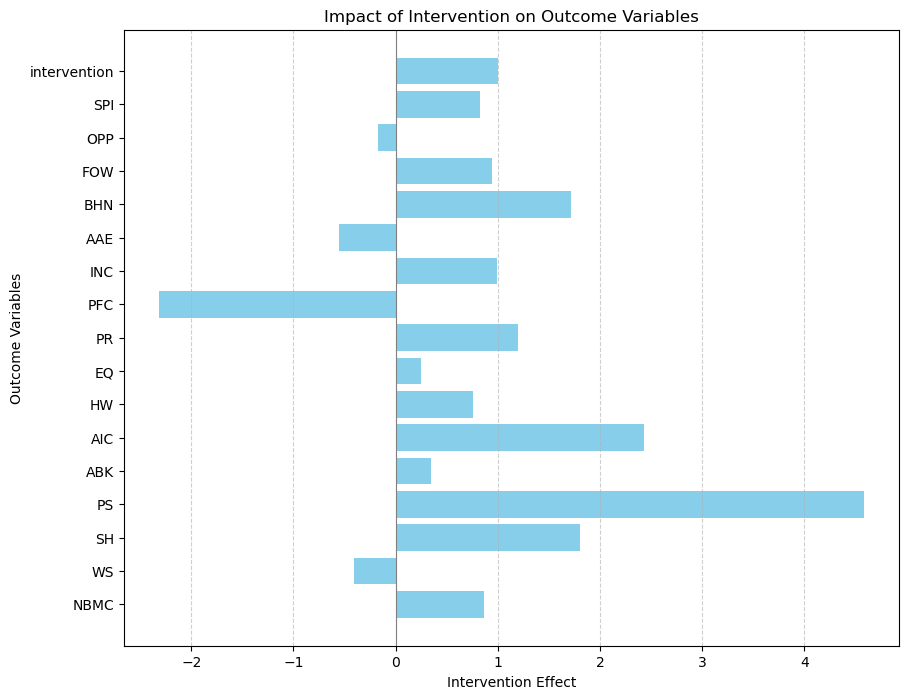

In [11]:
import matplotlib.pyplot as plt

# Setting up the data for visualization
outcomes = summary_df['Outcome']
intervention_effects = summary_df['Intervention Coef']

# Creating the bar plot
plt.figure(figsize=(10, 8))
plt.barh(outcomes, intervention_effects, color='skyblue')
plt.xlabel('Intervention Effect')
plt.ylabel('Outcome Variables')
plt.title('Impact of Intervention on Outcome Variables')
plt.axvline(x=0, color='grey', lw=0.8)  # Adds a vertical line at x=0 for reference
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Displaying the plot
plt.show()


In [12]:
# Initialize a dictionary to store the DID results for each GEOID and each outcome variable
did_results = {}

# Identify all the outcome variables in the dataset (excluding GEOID, Habitat, and Year)
outcome_variables = data.columns.difference(['GEOID', 'Habitat', 'Year'])

# Iterate over each unique GEOID
for geoid in data['GEOID'].unique():
    did_results[geoid] = {}
    # Subset the data for the current GEOID
    subset_data = data[data['GEOID'] == geoid]

    # Iterate over each outcome variable
    for outcome_var in outcome_variables:
        # Prepare the subset data for DID analysis
        subset_data['PostIntervention'] = np.where(subset_data['Year'] == 2022, 1, 0)
        subset_data['Treatment'] = subset_data['Habitat']  # Using 'Habitat' as the treatment indicator
        subset_data['TreatmentXPost'] = subset_data['Treatment'] * subset_data['PostIntervention']

        # Define the DID model formula for the current outcome variable
        did_formula = f'{outcome_var} ~ Treatment + PostIntervention + TreatmentXPost'

        # Fit the DID regression model using OLS for the subsetted data and current outcome variable
        did_result = smf.ols(formula=did_formula, data=subset_data).fit()

        # Store the coefficient of interest and its p-value for the current outcome variable
        treatment_x_post_coefficient = did_result.params['TreatmentXPost']
        treatment_x_post_pvalue = did_result.pvalues['TreatmentXPost']

        # Compile the results for the current GEOID and outcome variable
        did_results[geoid][outcome_var] = {
            'Coefficient': treatment_x_post_coefficient,
            'P-Value': treatment_x_post_pvalue
        }

# Since the output might be large, let's show a summary for one GEOID to check the structure
# We can adjust the display or processing based on user needs or save the results to a file
did_results[next(iter(did_results))]  # Display results for the first GEOID in the dictionary


C:\Users\PC2\AppData\Local\Temp\ipykernel_22408\1096520279.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data['PostIntervention'] = np.where(subset_data['Year'] == 2022, 1, 0)
C:\Users\PC2\AppData\Local\Temp\ipykernel_22408\1096520279.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data['Treatment'] = subset_data['Habitat']  # Using 'Habitat' as the treatment indicator
C:\Users\PC2\AppData\Local\Temp\ipykernel_22408\1096520279.py:18: SettingWithCopyWarning: 
A value is trying to be

{'AAE': {'Coefficient': 0.0, 'P-Value': nan},
 'ABK': {'Coefficient': 0.0, 'P-Value': nan},
 'AIC': {'Coefficient': 0.0, 'P-Value': nan},
 'BHN': {'Coefficient': 0.0, 'P-Value': nan},
 'EQ': {'Coefficient': 0.0, 'P-Value': nan},
 'FOW': {'Coefficient': 0.0, 'P-Value': nan},
 'HW': {'Coefficient': 0.0, 'P-Value': nan},
 'INC': {'Coefficient': 0.0, 'P-Value': nan},
 'NBMC': {'Coefficient': 0.0, 'P-Value': nan},
 'OPP': {'Coefficient': 0.0, 'P-Value': nan},
 'PFC': {'Coefficient': 0.0, 'P-Value': nan},
 'PR': {'Coefficient': 0.0, 'P-Value': nan},
 'PS': {'Coefficient': 0.0, 'P-Value': nan},
 'SH': {'Coefficient': 0.0, 'P-Value': nan},
 'SPI': {'Coefficient': 0.0, 'P-Value': nan},
 'WS': {'Coefficient': 0.0, 'P-Value': nan},
 'intervention': {'Coefficient': 0.0, 'P-Value': nan}}

In [13]:
did_results

{12095010300: {'AAE': {'Coefficient': 0.0, 'P-Value': nan},
  'ABK': {'Coefficient': 0.0, 'P-Value': nan},
  'AIC': {'Coefficient': 0.0, 'P-Value': nan},
  'BHN': {'Coefficient': 0.0, 'P-Value': nan},
  'EQ': {'Coefficient': 0.0, 'P-Value': nan},
  'FOW': {'Coefficient': 0.0, 'P-Value': nan},
  'HW': {'Coefficient': 0.0, 'P-Value': nan},
  'INC': {'Coefficient': 0.0, 'P-Value': nan},
  'NBMC': {'Coefficient': 0.0, 'P-Value': nan},
  'OPP': {'Coefficient': 0.0, 'P-Value': nan},
  'PFC': {'Coefficient': 0.0, 'P-Value': nan},
  'PR': {'Coefficient': 0.0, 'P-Value': nan},
  'PS': {'Coefficient': 0.0, 'P-Value': nan},
  'SH': {'Coefficient': 0.0, 'P-Value': nan},
  'SPI': {'Coefficient': 0.0, 'P-Value': nan},
  'WS': {'Coefficient': 0.0, 'P-Value': nan},
  'intervention': {'Coefficient': 0.0, 'P-Value': nan}},
 12095010400: {'AAE': {'Coefficient': 0.0, 'P-Value': nan},
  'ABK': {'Coefficient': 0.0, 'P-Value': nan},
  'AIC': {'Coefficient': 0.0, 'P-Value': nan},
  'BHN': {'Coefficient': 0.0,

In [14]:
# Define the path for the output text file
output_file_path = 'didd_regression_results.txt'

# Open the file in write mode
with open(output_file_path, 'w') as file:
    # Iterate through the results dictionary
    for geoid, outcomes in did_results.items():
        file.write(f'GEOID: {geoid}\n')
        for outcome, stats in outcomes.items():
            file.write(f'\tOutcome: {outcome}, Coefficient: {stats["Coefficient"]}, P-Value: {stats["P-Value"]}\n')
        file.write('\n')  # Add an empty line for readability between GEOIDs

# Return the path to the output file
output_file_path


'didd_regression_results.txt'